<a href="https://colab.research.google.com/github/Agarshan29/NeuroDetect/blob/main/models/Glioma_Grade_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python matplotlib scikit-learn nibabel

import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nibabel as nib
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import gc
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

base_path = '/content/drive/MyDrive/MICCAI_BraTS_2019_Data_Training'


def validate_dataset(base_path):
    required_folders = ['HGG', 'LGG']
    if not os.path.exists(base_path):
        raise FileNotFoundError(f"Dataset path {base_path} not found!")

    missing = []
    for folder in required_folders:
        path = os.path.join(base_path, folder)
        if not os.path.exists(path):
            missing.append(folder)

    if missing:
        raise FileNotFoundError(f"Missing folders: {', '.join(missing)}")
    else:
        print("Dataset validation successful!")

validate_dataset(base_path)


Dataset validation successful!


In [ ]:
#List patients with grades
def create_patient_dataset(base_path, modalities=['flair', 't1ce'], slice_range=(60, 100)):
    """Create a mapping of patients to their class labels"""
    patient_data = {}

    print("Finding LGG scans...")
    lgg_path = os.path.join(base_path, 'LGG')
    lgg_patients = [f for f in os.listdir(lgg_path) if os.path.isdir(os.path.join(lgg_path, f))]
    print(f"Found {len(lgg_patients)} potential patient folders in LGG.")

    print("Finding HGG scans...")
    hgg_path = os.path.join(base_path, 'HGG')
    hgg_patients = [f for f in os.listdir(hgg_path) if os.path.isdir(os.path.join(hgg_path, f))]
    print(f"Found {len(hgg_patients)} potential patient folders in HGG.")

    for patient in lgg_patients:
        patient_data[patient] = 0

    for patient in hgg_patients:
        patient_data[patient] = 1

    return patient_data, lgg_patients, hgg_patients

patient_data, lgg_patients, hgg_patients = create_patient_dataset(base_path)


Finding LGG scans...
Found 76 potential patient folders in LGG.
Finding HGG scans...
Found 259 potential patient folders in HGG.


In [ ]:
#Preprocess
def process_patient(patient_path, patient, modalities, slice_range):
    """Process a single patient and return slices"""
    try:
        volumes = [] ]
        for mod in modalities:
            mod_file = os.path.join(patient_path, f"{patient}_{mod}.nii.gz")
            if not os.path.exists(mod_file):
                mod_file = os.path.join(patient_path, f"{patient}_{mod}.nii")

            img = nib.load(mod_file).get_fdata()
            volumes.append(img)

        slices = []
        for slice_idx in range(*slice_range):
            if all(slice_idx < vol.shape[2] for vol in volumes):
                slice_data = []
                for vol in volumes:
                    slc = vol[:, :, slice_idx]
                    slc = cv2.resize(slc, (224, 224))
                    slice_data.append(slc)

                   # Stack the processed Flair and T1ce slices together.
                slices.append(np.stack(slice_data, axis=-1))

        return slices
    except Exception as e:
        print(f"Error processing {patient}: {str(e)}")
        return []

patients = list(patient_data.keys())
train_patients, temp_patients = train_test_split(
    patients, test_size=0.3, random_state=42,
    stratify=[patient_data[p] for p in patients]
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=42,
    stratify=[patient_data[p] for p in temp_patients]
)

print(f"Training patients: {len(train_patients)}")
print(f"Validation patients: {len(val_patients)}")
print(f"Test patients: {len(test_patients)}")

train_lgg = sum(1 for p in train_patients if patient_data[p] == 0)
train_hgg = sum(1 for p in train_patients if patient_data[p] == 1)
val_lgg = sum(1 for p in val_patients if patient_data[p] == 0)
val_hgg = sum(1 for p in val_patients if patient_data[p] == 1)
test_lgg = sum(1 for p in test_patients if patient_data[p] == 0)
test_hgg = sum(1 for p in test_patients if patient_data[p] == 1)

print(f"Training: LGG - {train_lgg}, HGG - {train_hgg}")
print(f"Validation: LGG - {val_lgg}, HGG - {val_hgg}")
print(f"Test: LGG - {test_lgg}, HGG - {test_hgg}")

# Saving patient splits for later use
np.save('train_patients.npy', train_patients)
np.save('val_patients.npy', val_patients)
np.save('test_patients.npy', test_patients)


Training patients: 234
Validation patients: 50
Test patients: 51
Training: LGG - 53, HGG - 181
Validation: LGG - 11, HGG - 39
Test: LGG - 12, HGG - 39


In [ ]:
class BrainTumorGenerator:
    def __init__(self, patients, patient_data, base_path, modalities=['flair', 't1ce'],
                slice_range=(60, 100), batch_size=16, augment=False, balance_classes=False):
        self.patients = patients
        self.patient_data = patient_data
        self.base_path = base_path
        self.modalities = modalities
        self.slice_range = slice_range
        self.batch_size = batch_size
        self.augment = augment
        self.balance_classes = balance_classes

        # Patient to class mapping
        self.lgg_patients = [p for p in patients if patient_data[p] == 0]
        self.hgg_patients = [p for p in patients if patient_data[p] == 1]

        # Augmentation generators
        if augment:
            self.lgg_datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )

            self.hgg_datagen = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest'
            )



    def __iter__(self):
        return self

    def __next__(self):
        if self.balance_classes and self.augment:

            lgg_batch_size = self.batch_size // 2
            hgg_batch_size = self.batch_size - lgg_batch_size

            # Sample patients
            lgg_batch_patients = np.random.choice(self.lgg_patients,
                                                size=min(lgg_batch_size, len(self.lgg_patients)),
                                                replace=False)
            hgg_batch_patients = np.random.choice(self.hgg_patients,
                                                size=min(hgg_batch_size, len(self.hgg_patients)),
                                                replace=False)


            X_lgg, y_lgg = [], []
            for patient in lgg_batch_patients:
                class_name = 'LGG'
                patient_path = os.path.join(self.base_path, class_name, patient)
                slices = process_patient(patient_path, patient, self.modalities, self.slice_range)
                if slices:

                    slice_idx = np.random.randint(0, len(slices))
                    X_lgg.append(slices[slice_idx])
                    y_lgg.append(0)

            # HGG patients
            X_hgg, y_hgg = [], []
            for patient in hgg_batch_patients:
                class_name = 'HGG'
                patient_path = os.path.join(self.base_path, class_name, patient)
                slices = process_patient(patient_path, patient, self.modalities, self.slice_range)
                if slices:

                    slice_idx = np.random.randint(0, len(slices))
                    X_hgg.append(slices[slice_idx])
                    y_hgg.append(1)

            # Convert to numpy arrays
            X_lgg = np.array(X_lgg)
            y_lgg = np.array(y_lgg)
            X_hgg = np.array(X_hgg)
            y_hgg = np.array(y_hgg)

            # augmentation
            if len(X_lgg) > 0:
                X_lgg = next(self.lgg_datagen.flow(X_lgg, y_lgg, batch_size=len(X_lgg)))[0]

            if len(X_hgg) > 0:
                X_hgg = next(self.hgg_datagen.flow(X_hgg, y_hgg, batch_size=len(X_hgg)))[0]

            # Combine batches
            X_batch = np.vstack([X_lgg, X_hgg]) if len(X_lgg) > 0 and len(X_hgg) > 0 else \
                    X_lgg if len(X_lgg) > 0 else X_hgg
            y_batch = np.concatenate([y_lgg, y_hgg]) if len(y_lgg) > 0 and len(y_hgg) > 0 else \
                    y_lgg if len(y_lgg) > 0 else y_hgg

            # Convert to RGB format
            X_batch_rgb = np.zeros((X_batch.shape[0], X_batch.shape[1], X_batch.shape[2], 3))
            X_batch_rgb[:, :, :, 0] = X_batch[:, :, :, 0]  # flair
            X_batch_rgb[:, :, :, 1] = X_batch[:, :, :, 1]  # t1ce
            X_batch_rgb[:, :, :, 2] = (X_batch[:, :, :, 0] + X_batch[:, :, :, 1]) / 2  # average

            # Shuffle
            indices = np.arange(len(X_batch_rgb))
            np.random.shuffle(indices)

            return X_batch_rgb[indices], y_batch[indices]

# generators
train_gen = BrainTumorGenerator(
    train_patients, patient_data, base_path,
    batch_size=16, augment=True, balance_classes=True
)

val_gen = BrainTumorGenerator(
    val_patients, patient_data, base_path,
    batch_size=16, augment=False, balance_classes=False
)

test_gen = BrainTumorGenerator(
    test_patients, patient_data, base_path,
    batch_size=16, augment=False, balance_classes=False
)


In [ ]:
def create_hybrid_model(input_shape=(224, 224, 3)):
    input_tensor = layers.Input(shape=input_shape)

    base_model1 = applications.ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor
    )

    base_model2 = applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor
    )

    for layer in base_model1.layers[:-30]:
        layer.trainable = False

    for layer in base_model2.layers[:-20]:
        layer.trainable = False

    x1 = base_model1.output
    x1 = layers.GlobalAveragePooling2D()(x1)
    x1 = layers.Dense(512, activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.5)(x1)

    x2 = base_model2.output
    x2 = layers.GlobalAveragePooling2D()(x2)
    x2 = layers.Dense(512, activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.5)(x2)

    combined = layers.Concatenate()([x1, x2])

    attention = layers.Dense(1024, activation='tanh')(combined)
    attention = layers.Dense(1024, activation='sigmoid')(attention)
    attention_output = layers.Multiply()([combined, attention])

    x = layers.Dense(256, activation='relu')(attention_output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=input_tensor, outputs=predictions)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# Create the model
model = create_hybrid_model()
model.summary()


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 31,719,588 (121.00 MB)

 Trainable params: 19,896,881 (75.90 MB)

 Non-trainable params: 11,822,707 (45.10 MB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 224, 224, 2) (2 channels).
  warnings.warn(


Step 10/100 - loss: 0.8843 - accuracy: 0.4360
Step 20/100 - loss: 0.8633 - accuracy: 0.4868
Step 30/100 - loss: 0.8531 - accuracy: 0.5054
Step 40/100 - loss: 0.8441 - accuracy: 0.5159
Step 50/100 - loss: 0.8372 - accuracy: 0.5252
Step 60/100 - loss: 0.8308 - accuracy: 0.5317
Step 70/100 - loss: 0.8225 - accuracy: 0.5386
Step 80/100 - loss: 0.8147 - accuracy: 0.5451
Step 90/100 - loss: 0.8063 - accuracy: 0.5517
Step 100/100 - loss: 0.7982 - accuracy: 0.5580
Epoch 1/50 - loss: 0.7982 - accuracy: 0.5580 - auc: 0.6162 - val_loss: 0.6707 - val_accuracy: 0.6498 - val_auc: 0.7098


Model saved with val_auc: 0.7098
Epoch 2/50
Step 10/100 - loss: 0.6395 - accuracy: 0.6704
Step 20/100 - loss: 0.6366 - accuracy: 0.6725
Step 30/100 - loss: 0.6331 - accuracy: 0.6746
Step 40/100 - loss: 0.6298 - accuracy: 0.6767
Step 50/100 - loss: 0.6265 - accuracy: 0.6786
Step 60/100 - loss: 0.6237 - accuracy: 0.6804
Step 70/100 - loss: 0.6205 - accuracy: 0.6822
Step 80/100 - loss: 0.6172 - accuracy: 0.6841
Step 90/100 - loss: 0.6140 - accuracy: 0.6858
Step 100/100 - loss: 0.6108 - accuracy: 0.6876
Epoch 2/50 - loss: 0.6108 - accuracy: 0.6876 - auc: 0.7552 - val_loss: 0.5636 - val_accuracy: 0.7150 - val_auc: 0.7921


Model saved with val_auc: 0.7921
Epoch 3/50
Step 10/100 - loss: 0.5465 - accuracy: 0.7251
Step 20/100 - loss: 0.5442 - accuracy: 0.7267
Step 30/100 - loss: 0.5414 - accuracy: 0.7285
Step 40/100 - loss: 0.5383 - accuracy: 0.7306
Step 50/100 - loss: 0.5352 - accuracy: 0.7324
Step 60/100 - loss: 0.5319 - accuracy: 0.7345
Step 70/100 - loss: 0.5286 - accuracy: 0.7364
Step 80/100 - loss: 0.5255 - accuracy: 0.7383
Step 90/100 - loss: 0.5225 - accuracy: 0.7401
Step 100/100 - loss: 0.5198 - accuracy: 0.7417
Epoch 3/50 - loss: 0.5198 - accuracy: 0.7417 - auc: 0.8228 - val_loss: 0.4955 - val_accuracy: 0.7605 - val_auc: 0.8425


Model saved with val_auc: 0.8425
Epoch 4/50
Step 10/100 - loss: 0.4938 - accuracy: 0.7646
Step 20/100 - loss: 0.4910 - accuracy: 0.7661
Step 30/100 - loss: 0.4880 - accuracy: 0.7677
Step 40/100 - loss: 0.4852 - accuracy: 0.7693
Step 50/100 - loss: 0.4825 - accuracy: 0.7708
Step 60/100 - loss: 0.4798 - accuracy: 0.7723
Step 70/100 - loss: 0.4773 - accuracy: 0.7737
Step 80/100 - loss: 0.4749 - accuracy: 0.7750
Step 90/100 - loss: 0.4725 - accuracy: 0.7764
Step 100/100 - loss: 0.4700 - accuracy: 0.7776
Epoch 4/50 - loss: 0.4700 - accuracy: 0.7776 - auc: 0.8594 - val_loss: 0.4432 - val_accuracy: 0.7931 - val_auc: 0.8755


Model saved with val_auc: 0.8755
Epoch 5/50
Step 10/100 - loss: 0.4385 - accuracy: 0.7963
Step 20/100 - loss: 0.4366 - accuracy: 0.7971
Step 30/100 - loss: 0.4349 - accuracy: 0.7980
Step 40/100 - loss: 0.4330 - accuracy: 0.7989
Step 50/100 - loss: 0.4312 - accuracy: 0.7998
Step 60/100 - loss: 0.4294 - accuracy: 0.8007
Step 70/100 - loss: 0.4277 - accuracy: 0.8016
Step 80/100 - loss: 0.4259 - accuracy: 0.8026
Step 90/100 - loss: 0.4241 - accuracy: 0.8035
Step 100/100 - loss: 0.4222 - accuracy: 0.8044
Epoch 5/50 - loss: 0.4222 - accuracy: 0.8044 - auc: 0.8875 - val_loss: 0.4016 - val_accuracy: 0.8155 - val_auc: 0.8987


Model saved with val_auc: 0.8987
Epoch 6/50
Step 10/100 - loss: 0.3985 - accuracy: 0.8180
Step 20/100 - loss: 0.3971 - accuracy: 0.8187
Step 30/100 - loss: 0.3958 - accuracy: 0.8194
Step 40/100 - loss: 0.3944 - accuracy: 0.8201
Step 50/100 - loss: 0.3930 - accuracy: 0.8208
Step 60/100 - loss: 0.3916 - accuracy: 0.8216
Step 70/100 - loss: 0.3902 - accuracy: 0.8223
Step 80/100 - loss: 0.3888 - accuracy: 0.8231
Step 90/100 - loss: 0.3874 - accuracy: 0.8238
Step 100/100 - loss: 0.3860 - accuracy: 0.8245
Epoch 6/50 - loss: 0.3860 - accuracy: 0.8245 - auc: 0.9069 - val_loss: 0.3820 - val_accuracy: 0.8311 - val_auc: 0.9109


Model saved with val_auc: 0.9109
Epoch 7/50
Step 10/100 - loss: 0.3931 - accuracy: 0.8306
Step 20/100 - loss: 0.3921 - accuracy: 0.8310
Step 30/100 - loss: 0.3912 - accuracy: 0.8314
Step 40/100 - loss: 0.3901 - accuracy: 0.8319
Step 50/100 - loss: 0.3892 - accuracy: 0.8324
Step 60/100 - loss: 0.3882 - accuracy: 0.8329
Step 70/100 - loss: 0.3873 - accuracy: 0.8334
Step 80/100 - loss: 0.3863 - accuracy: 0.8339
Step 90/100 - loss: 0.3853 - accuracy: 0.8344
Step 100/100 - loss: 0.3843 - accuracy: 0.8348
Epoch 7/50 - loss: 0.3843 - accuracy: 0.8348 - auc: 0.9123 - val_loss: 0.3798 - val_accuracy: 0.8392 - val_auc: 0.9155


Model saved with val_auc: 0.9155
Epoch 8/50
Step 10/100 - loss: 0.3820 - accuracy: 0.8396
Step 20/100 - loss: 0.3807 - accuracy: 0.8402
Step 30/100 - loss: 0.3794 - accuracy: 0.8407
Step 40/100 - loss: 0.3781 - accuracy: 0.8413
Step 50/100 - loss: 0.3769 - accuracy: 0.8418
Step 60/100 - loss: 0.3757 - accuracy: 0.8424
Step 70/100 - loss: 0.3745 - accuracy: 0.8429
Step 80/100 - loss: 0.3733 - accuracy: 0.8434
Step 90/100 - loss: 0.3721 - accuracy: 0.8439
Step 100/100 - loss: 0.3710 - accuracy: 0.8444
Epoch 8/50 - loss: 0.3710 - accuracy: 0.8444 - auc: 0.9197 - val_loss: 0.3611 - val_accuracy: 0.8489 - val_auc: 0.9241


Model saved with val_auc: 0.9241
Epoch 9/50
Step 10/100 - loss: 0.3612 - accuracy: 0.8489
Step 20/100 - loss: 0.3602 - accuracy: 0.8493
Step 30/100 - loss: 0.3593 - accuracy: 0.8498
Step 40/100 - loss: 0.3583 - accuracy: 0.8502
Step 50/100 - loss: 0.3573 - accuracy: 0.8507
Step 60/100 - loss: 0.3565 - accuracy: 0.8511
Step 70/100 - loss: 0.3557 - accuracy: 0.8515
Step 80/100 - loss: 0.3549 - accuracy: 0.8519
Step 90/100 - loss: 0.3540 - accuracy: 0.8523
Step 100/100 - loss: 0.3532 - accuracy: 0.8527
Epoch 9/50 - loss: 0.3532 - accuracy: 0.8527 - auc: 0.9275 - val_loss: 0.3465 - val_accuracy: 0.8563 - val_auc: 0.9304


Model saved with val_auc: 0.9304
Epoch 10/50
Step 10/100 - loss: 0.3470 - accuracy: 0.8564
Step 20/100 - loss: 0.3461 - accuracy: 0.8568
Step 30/100 - loss: 0.3451 - accuracy: 0.8573
Step 40/100 - loss: 0.3441 - accuracy: 0.8577
Step 50/100 - loss: 0.3432 - accuracy: 0.8581
Step 60/100 - loss: 0.3423 - accuracy: 0.8585
Step 70/100 - loss: 0.3414 - accuracy: 0.8589
Step 80/100 - loss: 0.3405 - accuracy: 0.8593
Step 90/100 - loss: 0.3397 - accuracy: 0.8597
Step 100/100 - loss: 0.3388 - accuracy: 0.8601
Epoch 10/50 - loss: 0.3388 - accuracy: 0.8601 - auc: 0.9335 - val_loss: 0.3404 - val_accuracy: 0.8632 - val_auc: 0.9342


Model saved with val_auc: 0.9342
Epoch 11/50
Step 10/100 - loss: 0.3493 - accuracy: 0.8628
Step 20/100 - loss: 0.3483 - accuracy: 0.8632
Step 30/100 - loss: 0.3475 - accuracy: 0.8635
Step 40/100 - loss: 0.3466 - accuracy: 0.8639
Step 50/100 - loss: 0.3457 - accuracy: 0.8642
Step 60/100 - loss: 0.3449 - accuracy: 0.8645
Step 70/100 - loss: 0.3441 - accuracy: 0.8648
Step 80/100 - loss: 0.3432 - accuracy: 0.8651
Step 90/100 - loss: 0.3424 - accuracy: 0.8655
Step 100/100 - loss: 0.3416 - accuracy: 0.8658
Epoch 11/50 - loss: 0.3416 - accuracy: 0.8658 - auc: 0.9348 - val_loss: 0.3395 - val_accuracy: 0.8678 - val_auc: 0.9360


Model saved with val_auc: 0.9360
Epoch 12/50
Step 10/100 - loss: 0.3440 - accuracy: 0.8672
Step 20/100 - loss: 0.3433 - accuracy: 0.8675
Step 30/100 - loss: 0.3426 - accuracy: 0.8678
Step 40/100 - loss: 0.3420 - accuracy: 0.8680
Step 50/100 - loss: 0.3413 - accuracy: 0.8683
Step 60/100 - loss: 0.3406 - accuracy: 0.8685
Step 70/100 - loss: 0.3399 - accuracy: 0.8688
Step 80/100 - loss: 0.3392 - accuracy: 0.8691
Step 90/100 - loss: 0.3385 - accuracy: 0.8694
Step 100/100 - loss: 0.3379 - accuracy: 0.8696
Epoch 12/50 - loss: 0.3379 - accuracy: 0.8696 - auc: 0.9370 - val_loss: 0.3329 - val_accuracy: 0.8721 - val_auc: 0.9388


Model saved with val_auc: 0.9388
Epoch 13/50
Step 10/100 - loss: 0.3336 - accuracy: 0.8722
Step 20/100 - loss: 0.3330 - accuracy: 0.8725
Step 30/100 - loss: 0.3324 - accuracy: 0.8727
Step 40/100 - loss: 0.3318 - accuracy: 0.8729
Step 50/100 - loss: 0.3311 - accuracy: 0.8731
Step 60/100 - loss: 0.3305 - accuracy: 0.8734
Step 70/100 - loss: 0.3299 - accuracy: 0.8736
Step 80/100 - loss: 0.3293 - accuracy: 0.8738
Step 90/100 - loss: 0.3286 - accuracy: 0.8741
Step 100/100 - loss: 0.3280 - accuracy: 0.8743
Epoch 13/50 - loss: 0.3280 - accuracy: 0.8743 - auc: 0.9406 - val_loss: 0.3240 - val_accuracy: 0.8762 - val_auc: 0.9421


Model saved with val_auc: 0.9421
Epoch 14/50
Step 10/100 - loss: 0.3250 - accuracy: 0.8760
Step 20/100 - loss: 0.3245 - accuracy: 0.8762
Step 30/100 - loss: 0.3240 - accuracy: 0.8764
Step 40/100 - loss: 0.3234 - accuracy: 0.8767
Step 50/100 - loss: 0.3229 - accuracy: 0.8769
Step 60/100 - loss: 0.3224 - accuracy: 0.8771
Step 70/100 - loss: 0.3218 - accuracy: 0.8773
Step 80/100 - loss: 0.3213 - accuracy: 0.8776
Step 90/100 - loss: 0.3207 - accuracy: 0.8778
Step 100/100 - loss: 0.3201 - accuracy: 0.8780
Epoch 14/50 - loss: 0.3201 - accuracy: 0.8780 - auc: 0.9435 - val_loss: 0.3174 - val_accuracy: 0.8796 - val_auc: 0.9445


Model saved with val_auc: 0.9445
Epoch 15/50
Step 10/100 - loss: 0.3200 - accuracy: 0.8794
Step 20/100 - loss: 0.3195 - accuracy: 0.8796
Step 30/100 - loss: 0.3189 - accuracy: 0.8799
Step 40/100 - loss: 0.3182 - accuracy: 0.8801
Step 50/100 - loss: 0.3176 - accuracy: 0.8803
Step 60/100 - loss: 0.3171 - accuracy: 0.8806
Step 70/100 - loss: 0.3166 - accuracy: 0.8808
Step 80/100 - loss: 0.3160 - accuracy: 0.8810
Step 90/100 - loss: 0.3155 - accuracy: 0.8812
Step 100/100 - loss: 0.3149 - accuracy: 0.8814
Epoch 15/50 - loss: 0.3149 - accuracy: 0.8814 - auc: 0.9454 - val_loss: 0.3123 - val_accuracy: 0.8829 - val_auc: 0.9464


Model saved with val_auc: 0.9464
Epoch 16/50
Step 10/100 - loss: 0.3141 - accuracy: 0.8825
Step 20/100 - loss: 0.3136 - accuracy: 0.8827
Step 30/100 - loss: 0.3131 - accuracy: 0.8829
Step 40/100 - loss: 0.3126 - accuracy: 0.8831
Step 50/100 - loss: 0.3121 - accuracy: 0.8833
Step 60/100 - loss: 0.3115 - accuracy: 0.8835
Step 70/100 - loss: 0.3110 - accuracy: 0.8837
Step 80/100 - loss: 0.3104 - accuracy: 0.8839
Step 90/100 - loss: 0.3099 - accuracy: 0.8841
Step 100/100 - loss: 0.3094 - accuracy: 0.8843
Epoch 16/50 - loss: 0.3094 - accuracy: 0.8843 - auc: 0.9473 - val_loss: 0.3086 - val_accuracy: 0.8856 - val_auc: 0.9478


Model saved with val_auc: 0.9478
Epoch 17/50
Step 10/100 - loss: 0.3118 - accuracy: 0.8854
Step 20/100 - loss: 0.3113 - accuracy: 0.8856
Step 30/100 - loss: 0.3108 - accuracy: 0.8858
Step 40/100 - loss: 0.3103 - accuracy: 0.8859
Step 50/100 - loss: 0.3099 - accuracy: 0.8861
Step 60/100 - loss: 0.3094 - accuracy: 0.8863
Step 70/100 - loss: 0.3090 - accuracy: 0.8864
Step 80/100 - loss: 0.3085 - accuracy: 0.8866
Step 90/100 - loss: 0.3081 - accuracy: 0.8868
Step 100/100 - loss: 0.3076 - accuracy: 0.8869
Epoch 17/50 - loss: 0.3076 - accuracy: 0.8869 - auc: 0.9484 - val_loss: 0.3061 - val_accuracy: 0.8881 - val_auc: 0.9491


Model saved with val_auc: 0.9491
Epoch 18/50
Step 10/100 - loss: 0.3083 - accuracy: 0.8878
Step 20/100 - loss: 0.3078 - accuracy: 0.8879
Step 30/100 - loss: 0.3074 - accuracy: 0.8881
Step 40/100 - loss: 0.3070 - accuracy: 0.8882
Step 50/100 - loss: 0.3065 - accuracy: 0.8883
Step 60/100 - loss: 0.3061 - accuracy: 0.8885
Step 70/100 - loss: 0.3056 - accuracy: 0.8886
Step 80/100 - loss: 0.3052 - accuracy: 0.8888
Step 90/100 - loss: 0.3047 - accuracy: 0.8890
Step 100/100 - loss: 0.3042 - accuracy: 0.8891
Epoch 18/50 - loss: 0.3042 - accuracy: 0.8891 - auc: 0.9498 - val_loss: 0.3030 - val_accuracy: 0.8900 - val_auc: 0.9504


Model saved with val_auc: 0.9504
Epoch 19/50
Step 10/100 - loss: 0.3053 - accuracy: 0.8897
Step 20/100 - loss: 0.3049 - accuracy: 0.8899
Step 30/100 - loss: 0.3045 - accuracy: 0.8900
Step 40/100 - loss: 0.3040 - accuracy: 0.8902
Step 50/100 - loss: 0.3036 - accuracy: 0.8903
Step 60/100 - loss: 0.3032 - accuracy: 0.8905
Step 70/100 - loss: 0.3028 - accuracy: 0.8906
Step 80/100 - loss: 0.3024 - accuracy: 0.8908
Step 90/100 - loss: 0.3019 - accuracy: 0.8909
Step 100/100 - loss: 0.3015 - accuracy: 0.8911
Epoch 19/50 - loss: 0.3015 - accuracy: 0.8911 - auc: 0.9509 - val_loss: 0.3011 - val_accuracy: 0.8920 - val_auc: 0.9512


Model saved with val_auc: 0.9512
Epoch 20/50
Step 10/100 - loss: 0.3044 - accuracy: 0.8914
Step 20/100 - loss: 0.3041 - accuracy: 0.8916
Step 30/100 - loss: 0.3037 - accuracy: 0.8917
Step 40/100 - loss: 0.3033 - accuracy: 0.8919
Step 50/100 - loss: 0.3029 - accuracy: 0.8920
Step 60/100 - loss: 0.3024 - accuracy: 0.8922
Step 70/100 - loss: 0.3020 - accuracy: 0.8923
Step 80/100 - loss: 0.3016 - accuracy: 0.8925
Step 90/100 - loss: 0.3011 - accuracy: 0.8926
Step 100/100 - loss: 0.3007 - accuracy: 0.8928
Epoch 20/50 - loss: 0.3007 - accuracy: 0.8928 - auc: 0.9515 - val_loss: 0.2986 - val_accuracy: 0.8939 - val_auc: 0.9521


Model saved with val_auc: 0.9521
Epoch 21/50
Step 10/100 - loss: 0.3001 - accuracy: 0.8937
Step 20/100 - loss: 0.2996 - accuracy: 0.8939
Step 30/100 - loss: 0.2993 - accuracy: 0.8940
Step 40/100 - loss: 0.2989 - accuracy: 0.8941
Step 50/100 - loss: 0.2986 - accuracy: 0.8943
Step 60/100 - loss: 0.2982 - accuracy: 0.8944
Step 70/100 - loss: 0.2978 - accuracy: 0.8945
Step 80/100 - loss: 0.2975 - accuracy: 0.8947
Step 90/100 - loss: 0.2971 - accuracy: 0.8948
Step 100/100 - loss: 0.2967 - accuracy: 0.8949
Epoch 21/50 - loss: 0.2967 - accuracy: 0.8949 - auc: 0.9527 - val_loss: 0.2954 - val_accuracy: 0.8958 - val_auc: 0.9531


Model saved with val_auc: 0.9531
Epoch 22/50
Step 10/100 - loss: 0.2978 - accuracy: 0.8955
Step 20/100 - loss: 0.2973 - accuracy: 0.8956
Step 30/100 - loss: 0.2969 - accuracy: 0.8958
Step 40/100 - loss: 0.2966 - accuracy: 0.8959
Step 50/100 - loss: 0.2962 - accuracy: 0.8960
Step 60/100 - loss: 0.2958 - accuracy: 0.8962
Step 70/100 - loss: 0.2954 - accuracy: 0.8963
Step 80/100 - loss: 0.2950 - accuracy: 0.8965
Step 90/100 - loss: 0.2946 - accuracy: 0.8966
Step 100/100 - loss: 0.2942 - accuracy: 0.8968
Epoch 22/50 - loss: 0.2942 - accuracy: 0.8968 - auc: 0.9535 - val_loss: 0.2929 - val_accuracy: 0.8977 - val_auc: 0.9539


Model saved with val_auc: 0.9539
Epoch 23/50
Step 10/100 - loss: 0.2955 - accuracy: 0.8972
Step 20/100 - loss: 0.2952 - accuracy: 0.8974
Step 30/100 - loss: 0.2949 - accuracy: 0.8975
Step 40/100 - loss: 0.2946 - accuracy: 0.8976
Step 50/100 - loss: 0.2942 - accuracy: 0.8977
Step 60/100 - loss: 0.2939 - accuracy: 0.8978
Step 70/100 - loss: 0.2936 - accuracy: 0.8980
Step 80/100 - loss: 0.2932 - accuracy: 0.8981
Step 90/100 - loss: 0.2929 - accuracy: 0.8982
Step 100/100 - loss: 0.2925 - accuracy: 0.8983
Epoch 23/50 - loss: 0.2925 - accuracy: 0.8983 - auc: 0.9542 - val_loss: 0.2913 - val_accuracy: 0.8990 - val_auc: 0.9546


Model saved with val_auc: 0.9546
Epoch 24/50
Step 10/100 - loss: 0.2926 - accuracy: 0.8988
Step 20/100 - loss: 0.2922 - accuracy: 0.8989
Step 30/100 - loss: 0.2919 - accuracy: 0.8990
Step 40/100 - loss: 0.2915 - accuracy: 0.8991
Step 50/100 - loss: 0.2912 - accuracy: 0.8992
Step 60/100 - loss: 0.2908 - accuracy: 0.8994
Step 70/100 - loss: 0.2905 - accuracy: 0.8995
Step 80/100 - loss: 0.2902 - accuracy: 0.8996
Step 90/100 - loss: 0.2898 - accuracy: 0.8997
Step 100/100 - loss: 0.2895 - accuracy: 0.8999
Epoch 24/50 - loss: 0.2895 - accuracy: 0.8999 - auc: 0.9551 - val_loss: 0.2878 - val_accuracy: 0.9005 - val_auc: 0.9556


Model saved with val_auc: 0.9556
Epoch 25/50
Step 10/100 - loss: 0.2886 - accuracy: 0.9003
Step 20/100 - loss: 0.2883 - accuracy: 0.9004
Step 30/100 - loss: 0.2880 - accuracy: 0.9005
Step 40/100 - loss: 0.2876 - accuracy: 0.9006
Step 50/100 - loss: 0.2873 - accuracy: 0.9007
Step 60/100 - loss: 0.2869 - accuracy: 0.9008
Step 70/100 - loss: 0.2866 - accuracy: 0.9009
Step 80/100 - loss: 0.2863 - accuracy: 0.9010
Step 90/100 - loss: 0.2859 - accuracy: 0.9012
Step 100/100 - loss: 0.2856 - accuracy: 0.9013
Epoch 25/50 - loss: 0.2856 - accuracy: 0.9013 - auc: 0.9563 - val_loss: 0.2849 - val_accuracy: 0.9019 - val_auc: 0.9565


Model saved with val_auc: 0.9565
Epoch 26/50
Step 10/100 - loss: 0.2870 - accuracy: 0.9016
Step 20/100 - loss: 0.2866 - accuracy: 0.9017
Step 30/100 - loss: 0.2863 - accuracy: 0.9018
Step 40/100 - loss: 0.2860 - accuracy: 0.9019
Step 50/100 - loss: 0.2857 - accuracy: 0.9020
Step 60/100 - loss: 0.2854 - accuracy: 0.9021
Step 70/100 - loss: 0.2851 - accuracy: 0.9022
Step 80/100 - loss: 0.2848 - accuracy: 0.9023
Step 90/100 - loss: 0.2846 - accuracy: 0.9024
Step 100/100 - loss: 0.2843 - accuracy: 0.9025
Epoch 26/50 - loss: 0.2843 - accuracy: 0.9025 - auc: 0.9567 - val_loss: 0.2830 - val_accuracy: 0.9031 - val_auc: 0.9572


Model saved with val_auc: 0.9572
Epoch 27/50
Step 10/100 - loss: 0.2842 - accuracy: 0.9029
Step 20/100 - loss: 0.2839 - accuracy: 0.9030
Step 30/100 - loss: 0.2836 - accuracy: 0.9031
Step 40/100 - loss: 0.2833 - accuracy: 0.9032
Step 50/100 - loss: 0.2830 - accuracy: 0.9033
Step 60/100 - loss: 0.2827 - accuracy: 0.9034
Step 70/100 - loss: 0.2825 - accuracy: 0.9035
Step 80/100 - loss: 0.2822 - accuracy: 0.9036
Step 90/100 - loss: 0.2819 - accuracy: 0.9037
Step 100/100 - loss: 0.2816 - accuracy: 0.9038
Epoch 27/50 - loss: 0.2816 - accuracy: 0.9038 - auc: 0.9577 - val_loss: 0.2794 - val_accuracy: 0.9045 - val_auc: 0.9582


Model saved with val_auc: 0.9582
Epoch 28/50
Step 10/100 - loss: 0.2799 - accuracy: 0.9044
Step 20/100 - loss: 0.2796 - accuracy: 0.9044
Step 30/100 - loss: 0.2794 - accuracy: 0.9045
Step 40/100 - loss: 0.2791 - accuracy: 0.9046
Step 50/100 - loss: 0.2788 - accuracy: 0.9047
Step 60/100 - loss: 0.2786 - accuracy: 0.9048
Step 70/100 - loss: 0.2783 - accuracy: 0.9049
Step 80/100 - loss: 0.2780 - accuracy: 0.9050
Step 90/100 - loss: 0.2777 - accuracy: 0.9051
Step 100/100 - loss: 0.2774 - accuracy: 0.9052
Epoch 28/50 - loss: 0.2774 - accuracy: 0.9052 - auc: 0.9588 - val_loss: 0.2767 - val_accuracy: 0.9058 - val_auc: 0.9590


Model saved with val_auc: 0.9590
Epoch 29/50
Step 10/100 - loss: 0.2788 - accuracy: 0.9055
Step 20/100 - loss: 0.2785 - accuracy: 0.9056
Step 30/100 - loss: 0.2783 - accuracy: 0.9057
Step 40/100 - loss: 0.2780 - accuracy: 0.9058
Step 50/100 - loss: 0.2777 - accuracy: 0.9058
Step 60/100 - loss: 0.2775 - accuracy: 0.9059
Step 70/100 - loss: 0.2772 - accuracy: 0.9060
Step 80/100 - loss: 0.2770 - accuracy: 0.9061
Step 90/100 - loss: 0.2767 - accuracy: 0.9062
Step 100/100 - loss: 0.2765 - accuracy: 0.9063
Epoch 29/50 - loss: 0.2765 - accuracy: 0.9063 - auc: 0.9591 - val_loss: 0.2763 - val_accuracy: 0.9068 - val_auc: 0.9592


Model saved with val_auc: 0.9592
Epoch 30/50
Step 10/100 - loss: 0.2787 - accuracy: 0.9064
Step 20/100 - loss: 0.2784 - accuracy: 0.9064
Step 30/100 - loss: 0.2781 - accuracy: 0.9065
Step 40/100 - loss: 0.2779 - accuracy: 0.9066
Step 50/100 - loss: 0.2776 - accuracy: 0.9067
Step 60/100 - loss: 0.2773 - accuracy: 0.9068
Step 70/100 - loss: 0.2771 - accuracy: 0.9069
Step 80/100 - loss: 0.2769 - accuracy: 0.9070
Step 90/100 - loss: 0.2766 - accuracy: 0.9070
Step 100/100 - loss: 0.2764 - accuracy: 0.9071
Epoch 30/50 - loss: 0.2764 - accuracy: 0.9071 - auc: 0.9592 - val_loss: 0.2763 - val_accuracy: 0.9073 - val_auc: 0.9594


Model saved with val_auc: 0.9594
Epoch 31/50
Step 10/100 - loss: 0.2776 - accuracy: 0.9069
Step 20/100 - loss: 0.2773 - accuracy: 0.9070
Step 30/100 - loss: 0.2770 - accuracy: 0.9071
Step 40/100 - loss: 0.2768 - accuracy: 0.9072
Step 50/100 - loss: 0.2765 - accuracy: 0.9072
Step 60/100 - loss: 0.2763 - accuracy: 0.9073
Step 70/100 - loss: 0.2760 - accuracy: 0.9074
Step 80/100 - loss: 0.2758 - accuracy: 0.9075
Step 90/100 - loss: 0.2755 - accuracy: 0.9076
Step 100/100 - loss: 0.2753 - accuracy: 0.9077
Epoch 31/50 - loss: 0.2753 - accuracy: 0.9077 - auc: 0.9597 - val_loss: 0.2749 - val_accuracy: 0.9081 - val_auc: 0.9598


Model saved with val_auc: 0.9598
Epoch 32/50
Step 10/100 - loss: 0.2768 - accuracy: 0.9077
Step 20/100 - loss: 0.2766 - accuracy: 0.9078
Step 30/100 - loss: 0.2764 - accuracy: 0.9079
Step 40/100 - loss: 0.2762 - accuracy: 0.9079
Step 50/100 - loss: 0.2760 - accuracy: 0.9080
Step 60/100 - loss: 0.2757 - accuracy: 0.9081
Step 70/100 - loss: 0.2755 - accuracy: 0.9082
Step 80/100 - loss: 0.2752 - accuracy: 0.9083
Step 90/100 - loss: 0.2750 - accuracy: 0.9083
Step 100/100 - loss: 0.2747 - accuracy: 0.9084
Epoch 32/50 - loss: 0.2747 - accuracy: 0.9084 - auc: 0.9599 - val_loss: 0.2744 - val_accuracy: 0.9088 - val_auc: 0.9601


Model saved with val_auc: 0.9601
Epoch 33/50
Step 10/100 - loss: 0.2755 - accuracy: 0.9085
Step 20/100 - loss: 0.2753 - accuracy: 0.9086
Step 30/100 - loss: 0.2751 - accuracy: 0.9087
Step 40/100 - loss: 0.2748 - accuracy: 0.9087
Step 50/100 - loss: 0.2746 - accuracy: 0.9088
Step 60/100 - loss: 0.2743 - accuracy: 0.9089
Step 70/100 - loss: 0.2741 - accuracy: 0.9090
Step 80/100 - loss: 0.2738 - accuracy: 0.9091
Step 90/100 - loss: 0.2736 - accuracy: 0.9092
Step 100/100 - loss: 0.2734 - accuracy: 0.9092
Epoch 33/50 - loss: 0.2734 - accuracy: 0.9092 - auc: 0.9605 - val_loss: 0.2740 - val_accuracy: 0.9097 - val_auc: 0.9604


Model saved with val_auc: 0.9604
Epoch 34/50
Step 10/100 - loss: 0.2768 - accuracy: 0.9093
Step 20/100 - loss: 0.2766 - accuracy: 0.9094
Step 30/100 - loss: 0.2763 - accuracy: 0.9095
Step 40/100 - loss: 0.2761 - accuracy: 0.9096
Step 50/100 - loss: 0.2759 - accuracy: 0.9096
Step 60/100 - loss: 0.2756 - accuracy: 0.9097
Step 70/100 - loss: 0.2754 - accuracy: 0.9098
Step 80/100 - loss: 0.2752 - accuracy: 0.9099
Step 90/100 - loss: 0.2749 - accuracy: 0.9100
Step 100/100 - loss: 0.2747 - accuracy: 0.9100
Epoch 34/50 - loss: 0.2747 - accuracy: 0.9100 - auc: 0.9603 - val_loss: 0.2749 - val_accuracy: 0.9106 - val_auc: 0.9604
Epoch 35/50
Step 10/100 - loss: 0.2770 - accuracy: 0.9104
Step 20/100 - loss: 0.2767 - accuracy: 0.9105
Step 30/100 - loss: 0.2765 - accuracy: 0.9105
Step 40/100 - loss: 0.2762 - accuracy: 0.9106
Step 50/100 - loss: 0.2760 - accuracy: 0.9107
Step 60/100 - loss: 0.2758 - accuracy: 0.9108
Step 70/100 - loss: 0.2756 - accuracy: 0.9108
Step 80/100 - loss: 0.2754 - accuracy: 0

Model saved with val_auc: 0.9606
Epoch 36/50
Step 10/100 - loss: 0.2754 - accuracy: 0.9113
Step 20/100 - loss: 0.2752 - accuracy: 0.9114
Step 30/100 - loss: 0.2750 - accuracy: 0.9115
Step 40/100 - loss: 0.2748 - accuracy: 0.9115
Step 50/100 - loss: 0.2745 - accuracy: 0.9116
Step 60/100 - loss: 0.2743 - accuracy: 0.9117
Step 70/100 - loss: 0.2741 - accuracy: 0.9117
Step 80/100 - loss: 0.2738 - accuracy: 0.9118
Step 90/100 - loss: 0.2736 - accuracy: 0.9119
Step 100/100 - loss: 0.2734 - accuracy: 0.9120
Epoch 36/50 - loss: 0.2734 - accuracy: 0.9120 - auc: 0.9609 - val_loss: 0.2735 - val_accuracy: 0.9124 - val_auc: 0.9609


Model saved with val_auc: 0.9609
Epoch 37/50
Step 10/100 - loss: 0.2754 - accuracy: 0.9123
Step 20/100 - loss: 0.2752 - accuracy: 0.9123
Step 30/100 - loss: 0.2749 - accuracy: 0.9124
Step 40/100 - loss: 0.2747 - accuracy: 0.9125
Step 50/100 - loss: 0.2745 - accuracy: 0.9125
Step 60/100 - loss: 0.2743 - accuracy: 0.9126
Step 70/100 - loss: 0.2740 - accuracy: 0.9127
Step 80/100 - loss: 0.2738 - accuracy: 0.9128
Step 90/100 - loss: 0.2736 - accuracy: 0.9128
Step 100/100 - loss: 0.2734 - accuracy: 0.9129
Epoch 37/50 - loss: 0.2734 - accuracy: 0.9129 - auc: 0.9610 - val_loss: 0.2737 - val_accuracy: 0.9133 - val_auc: 0.9610


Model saved with val_auc: 0.9610
Epoch 38/50
Step 10/100 - loss: 0.2762 - accuracy: 0.9130
Step 20/100 - loss: 0.2760 - accuracy: 0.9131
Step 30/100 - loss: 0.2758 - accuracy: 0.9131
Step 40/100 - loss: 0.2756 - accuracy: 0.9132
Step 50/100 - loss: 0.2754 - accuracy: 0.9133
Step 60/100 - loss: 0.2751 - accuracy: 0.9133
Step 70/100 - loss: 0.2749 - accuracy: 0.9134
Step 80/100 - loss: 0.2747 - accuracy: 0.9135
Step 90/100 - loss: 0.2745 - accuracy: 0.9135
Step 100/100 - loss: 0.2742 - accuracy: 0.9136
Epoch 38/50 - loss: 0.2742 - accuracy: 0.9136 - auc: 0.9610 - val_loss: 0.2744 - val_accuracy: 0.9140 - val_auc: 0.9610
Epoch 39/50
Step 10/100 - loss: 0.2762 - accuracy: 0.9139
Step 20/100 - loss: 0.2760 - accuracy: 0.9140
Step 30/100 - loss: 0.2758 - accuracy: 0.9141
Step 40/100 - loss: 0.2755 - accuracy: 0.9141
Step 50/100 - loss: 0.2753 - accuracy: 0.9142
Step 60/100 - loss: 0.2751 - accuracy: 0.9143
Step 70/100 - loss: 0.2749 - accuracy: 0.9143
Step 80/100 - loss: 0.2747 - accuracy: 0

Model saved with val_auc: 0.9611
Epoch 40/50
Step 10/100 - loss: 0.2764 - accuracy: 0.9145
Step 20/100 - loss: 0.2762 - accuracy: 0.9145
Step 30/100 - loss: 0.2759 - accuracy: 0.9146
Step 40/100 - loss: 0.2757 - accuracy: 0.9147
Step 50/100 - loss: 0.2756 - accuracy: 0.9147
Step 60/100 - loss: 0.2754 - accuracy: 0.9148
Step 70/100 - loss: 0.2752 - accuracy: 0.9148
Step 80/100 - loss: 0.2750 - accuracy: 0.9149
Step 90/100 - loss: 0.2748 - accuracy: 0.9150
Step 100/100 - loss: 0.2746 - accuracy: 0.9150
Epoch 40/50 - loss: 0.2746 - accuracy: 0.9150 - auc: 0.9612 - val_loss: 0.2746 - val_accuracy: 0.9154 - val_auc: 0.9612


Model saved with val_auc: 0.9612
Epoch 41/50
Step 10/100 - loss: 0.2759 - accuracy: 0.9152
Step 20/100 - loss: 0.2757 - accuracy: 0.9153
Step 30/100 - loss: 0.2755 - accuracy: 0.9154
Step 40/100 - loss: 0.2753 - accuracy: 0.9154
Step 50/100 - loss: 0.2750 - accuracy: 0.9155
Step 60/100 - loss: 0.2748 - accuracy: 0.9156
Step 70/100 - loss: 0.2746 - accuracy: 0.9156
Step 80/100 - loss: 0.2744 - accuracy: 0.9157
Step 90/100 - loss: 0.2742 - accuracy: 0.9157
Step 100/100 - loss: 0.2740 - accuracy: 0.9158
Epoch 41/50 - loss: 0.2740 - accuracy: 0.9158 - auc: 0.9614 - val_loss: 0.2744 - val_accuracy: 0.9160 - val_auc: 0.9614


Model saved with val_auc: 0.9614
Epoch 42/50
Step 10/100 - loss: 0.2764 - accuracy: 0.9156
Step 20/100 - loss: 0.2762 - accuracy: 0.9157
Step 30/100 - loss: 0.2760 - accuracy: 0.9157
Step 40/100 - loss: 0.2758 - accuracy: 0.9158
Step 50/100 - loss: 0.2756 - accuracy: 0.9158
Step 60/100 - loss: 0.2754 - accuracy: 0.9159
Step 70/100 - loss: 0.2752 - accuracy: 0.9160
Step 80/100 - loss: 0.2750 - accuracy: 0.9160
Step 90/100 - loss: 0.2748 - accuracy: 0.9161
Step 100/100 - loss: 0.2746 - accuracy: 0.9161
Epoch 42/50 - loss: 0.2746 - accuracy: 0.9161 - auc: 0.9614 - val_loss: 0.2741 - val_accuracy: 0.9164 - val_auc: 0.9616


Model saved with val_auc: 0.9616
Epoch 43/50
Step 10/100 - loss: 0.2750 - accuracy: 0.9163
Step 20/100 - loss: 0.2748 - accuracy: 0.9163
Step 30/100 - loss: 0.2746 - accuracy: 0.9164
Step 40/100 - loss: 0.2744 - accuracy: 0.9164
Step 50/100 - loss: 0.2742 - accuracy: 0.9165
Step 60/100 - loss: 0.2741 - accuracy: 0.9166
Step 70/100 - loss: 0.2739 - accuracy: 0.9166
Step 80/100 - loss: 0.2737 - accuracy: 0.9167
Step 90/100 - loss: 0.2735 - accuracy: 0.9167
Step 100/100 - loss: 0.2733 - accuracy: 0.9168
Epoch 43/50 - loss: 0.2733 - accuracy: 0.9168 - auc: 0.9618 - val_loss: 0.2728 - val_accuracy: 0.9171 - val_auc: 0.9619


Model saved with val_auc: 0.9619
Epoch 44/50
Step 10/100 - loss: 0.2743 - accuracy: 0.9169
Step 20/100 - loss: 0.2741 - accuracy: 0.9170
Step 30/100 - loss: 0.2739 - accuracy: 0.9170
Step 40/100 - loss: 0.2737 - accuracy: 0.9171
Step 50/100 - loss: 0.2736 - accuracy: 0.9172
Step 60/100 - loss: 0.2734 - accuracy: 0.9172
Step 70/100 - loss: 0.2732 - accuracy: 0.9173
Step 80/100 - loss: 0.2730 - accuracy: 0.9173
Step 90/100 - loss: 0.2728 - accuracy: 0.9174
Step 100/100 - loss: 0.2727 - accuracy: 0.9174
Epoch 44/50 - loss: 0.2727 - accuracy: 0.9174 - auc: 0.9620 - val_loss: 0.2727 - val_accuracy: 0.9175 - val_auc: 0.9620


Model saved with val_auc: 0.9620
Epoch 45/50
Step 10/100 - loss: 0.2740 - accuracy: 0.9172
Step 20/100 - loss: 0.2738 - accuracy: 0.9172
Step 30/100 - loss: 0.2736 - accuracy: 0.9173
Step 40/100 - loss: 0.2734 - accuracy: 0.9173
Step 50/100 - loss: 0.2732 - accuracy: 0.9174
Step 60/100 - loss: 0.2731 - accuracy: 0.9174
Step 70/100 - loss: 0.2729 - accuracy: 0.9175
Step 80/100 - loss: 0.2727 - accuracy: 0.9176
Step 90/100 - loss: 0.2725 - accuracy: 0.9176
Step 100/100 - loss: 0.2723 - accuracy: 0.9177
Epoch 45/50 - loss: 0.2723 - accuracy: 0.9177 - auc: 0.9621 - val_loss: 0.2719 - val_accuracy: 0.9179 - val_auc: 0.9622


Model saved with val_auc: 0.9622
Epoch 46/50
Step 10/100 - loss: 0.2731 - accuracy: 0.9177
Step 20/100 - loss: 0.2730 - accuracy: 0.9177
Step 30/100 - loss: 0.2728 - accuracy: 0.9178
Step 40/100 - loss: 0.2726 - accuracy: 0.9178
Step 50/100 - loss: 0.2724 - accuracy: 0.9179
Step 60/100 - loss: 0.2722 - accuracy: 0.9179
Step 70/100 - loss: 0.2720 - accuracy: 0.9180
Step 80/100 - loss: 0.2718 - accuracy: 0.9181
Step 90/100 - loss: 0.2716 - accuracy: 0.9181
Step 100/100 - loss: 0.2715 - accuracy: 0.9182
Epoch 46/50 - loss: 0.2715 - accuracy: 0.9182 - auc: 0.9623 - val_loss: 0.2711 - val_accuracy: 0.9184 - val_auc: 0.9625


Model saved with val_auc: 0.9625
Epoch 47/50
Step 10/100 - loss: 0.2724 - accuracy: 0.9182
Step 20/100 - loss: 0.2722 - accuracy: 0.9183
Step 30/100 - loss: 0.2720 - accuracy: 0.9183
Step 40/100 - loss: 0.2719 - accuracy: 0.9184
Step 50/100 - loss: 0.2717 - accuracy: 0.9184
Step 60/100 - loss: 0.2715 - accuracy: 0.9185
Step 70/100 - loss: 0.2713 - accuracy: 0.9185
Step 80/100 - loss: 0.2711 - accuracy: 0.9186
Step 90/100 - loss: 0.2710 - accuracy: 0.9186
Step 100/100 - loss: 0.2708 - accuracy: 0.9187
Epoch 47/50 - loss: 0.2708 - accuracy: 0.9187 - auc: 0.9626 - val_loss: 0.2710 - val_accuracy: 0.9187 - val_auc: 0.9626


Model saved with val_auc: 0.9626
Epoch 48/50
Step 10/100 - loss: 0.2727 - accuracy: 0.9183
Step 20/100 - loss: 0.2726 - accuracy: 0.9184
Step 30/100 - loss: 0.2724 - accuracy: 0.9184
Step 40/100 - loss: 0.2722 - accuracy: 0.9185
Step 50/100 - loss: 0.2721 - accuracy: 0.9185
Step 60/100 - loss: 0.2719 - accuracy: 0.9186
Step 70/100 - loss: 0.2717 - accuracy: 0.9186
Step 80/100 - loss: 0.2716 - accuracy: 0.9187
Step 90/100 - loss: 0.2714 - accuracy: 0.9187
Step 100/100 - loss: 0.2713 - accuracy: 0.9188
Epoch 48/50 - loss: 0.2713 - accuracy: 0.9188 - auc: 0.9626 - val_loss: 0.2715 - val_accuracy: 0.9188 - val_auc: 0.9626


Model saved with val_auc: 0.9626
Epoch 49/50
Step 10/100 - loss: 0.2732 - accuracy: 0.9184
Step 20/100 - loss: 0.2730 - accuracy: 0.9185
Step 30/100 - loss: 0.2729 - accuracy: 0.9185
Step 40/100 - loss: 0.2727 - accuracy: 0.9186
Step 50/100 - loss: 0.2726 - accuracy: 0.9186
Step 60/100 - loss: 0.2724 - accuracy: 0.9186
Step 70/100 - loss: 0.2723 - accuracy: 0.9187
Step 80/100 - loss: 0.2721 - accuracy: 0.9187
Step 90/100 - loss: 0.2720 - accuracy: 0.9188
Step 100/100 - loss: 0.2718 - accuracy: 0.9188
Epoch 49/50 - loss: 0.2718 - accuracy: 0.9188 - auc: 0.9626 - val_loss: 0.2718 - val_accuracy: 0.9190 - val_auc: 0.9626


Model saved with val_auc: 0.9626
Epoch 50/50
Step 10/100 - loss: 0.2729 - accuracy: 0.9188
Step 20/100 - loss: 0.2727 - accuracy: 0.9188
Step 30/100 - loss: 0.2725 - accuracy: 0.9189
Step 40/100 - loss: 0.2723 - accuracy: 0.9189
Step 50/100 - loss: 0.2722 - accuracy: 0.9190
Step 60/100 - loss: 0.2720 - accuracy: 0.9190
Step 70/100 - loss: 0.2719 - accuracy: 0.9190
Step 80/100 - loss: 0.2717 - accuracy: 0.9191
Step 90/100 - loss: 0.2716 - accuracy: 0.9191
Step 100/100 - loss: 0.2714 - accuracy: 0.9192
Epoch 50/50 - loss: 0.2714 - accuracy: 0.9192 - auc: 0.9627 - val_loss: 0.2712 - val_accuracy: 0.9193 - val_auc: 0.9628


Model saved with val_auc: 0.9628


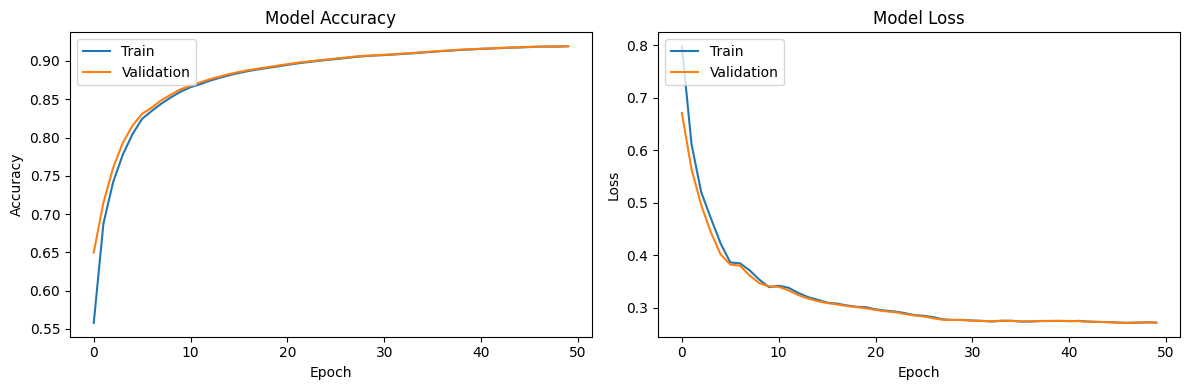

In [ ]:
# Setup callbacks
callbacks = [
    ModelCheckpoint(
        'brain_tumor_classifier.h5',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_auc',
        patience=10,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]


def train_model_with_generators(model, train_gen, val_gen, steps_per_epoch=100, validation_steps=50, epochs=30):
    history = {'loss': [], 'accuracy': [], 'auc': [], 'precision': [], 'recall': [],
               'val_loss': [], 'val_accuracy': [], 'val_auc': [], 'val_precision': [], 'val_recall': []}

    best_val_auc = 0
    patience_counter = 0
    best_weights = None

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training
        train_losses = []
        train_accuracies = []
        train_aucs = []
        train_precisions = []
        train_recalls = []

        for step in range(steps_per_epoch):
            X_batch, y_batch = next(iter(train_gen))


            metrics = model.train_on_batch(X_batch, y_batch)

            # metrics
            train_losses.append(metrics[0])
            train_accuracies.append(metrics[1])
            train_aucs.append(metrics[2])
            train_precisions.append(metrics[3])
            train_recalls.append(metrics[4])

            if (step + 1) % 10 == 0:
                print(f"Step {step+1}/{steps_per_epoch} - loss: {np.mean(train_losses):.4f} - accuracy: {np.mean(train_accuracies):.4f}")

            gc.collect()

        # Validation
        val_losses = []
        val_accuracies = []
        val_aucs = []
        val_precisions = []
        val_recalls = []

        for step in range(validation_steps):
            X_val_batch, y_val_batch = next(iter(val_gen))


            val_metrics = model.test_on_batch(X_val_batch, y_val_batch)

            # metrics
            val_losses.append(val_metrics[0])
            val_accuracies.append(val_metrics[1])
            val_aucs.append(val_metrics[2])
            val_precisions.append(val_metrics[3])
            val_recalls.append(val_metrics[4])

            gc.collect()

        # average metrics
        epoch_train_loss = np.mean(train_losses)
        epoch_train_accuracy = np.mean(train_accuracies)
        epoch_train_auc = np.mean(train_aucs)
        epoch_train_precision = np.mean(train_precisions)
        epoch_train_recall = np.mean(train_recalls)

        epoch_val_loss = np.mean(val_losses)
        epoch_val_accuracy = np.mean(val_accuracies)
        epoch_val_auc = np.mean(val_aucs)
        epoch_val_precision = np.mean(val_precisions)
        epoch_val_recall = np.mean(val_recalls)

        # history
        history['loss'].append(epoch_train_loss)
        history['accuracy'].append(epoch_train_accuracy)
        history['auc'].append(epoch_train_auc)
        history['precision'].append(epoch_train_precision)
        history['recall'].append(epoch_train_recall)

        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)
        history['val_auc'].append(epoch_val_auc)
        history['val_precision'].append(epoch_val_precision)
        history['val_recall'].append(epoch_val_recall)


        print(f"Epoch {epoch+1}/{epochs} - loss: {epoch_train_loss:.4f} - accuracy: {epoch_train_accuracy:.4f} - auc: {epoch_train_auc:.4f} - val_loss: {epoch_val_loss:.4f} - val_accuracy: {epoch_val_accuracy:.4f} - val_auc: {epoch_val_auc:.4f}")


        if epoch_val_auc > best_val_auc:
            best_val_auc = epoch_val_auc
            best_weights = model.get_weights()
            patience_counter = 0
            model.save('brain_tumor_classifier.h5')
            print(f"Model saved with val_auc: {best_val_auc:.4f}")
        else:
            patience_counter += 1


        if patience_counter >= 10:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if patience_counter >= 5:
            current_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
            new_lr = current_lr * 0.2
            tf.keras.backend.set_value(model.optimizer.lr, new_lr)
            print(f"Reduced learning rate from {current_lr} to {new_lr}")


    if best_weights is not None:
        model.set_weights(best_weights)

    return history, model


steps_per_epoch = 100
validation_steps = 50
history, model = train_model_with_generators(model, train_gen, val_gen,
                                            steps_per_epoch=steps_per_epoch,
                                            validation_steps=validation_steps,
                                            epochs=50)


np.save('training_history.npy', history)

# training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('training_history.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

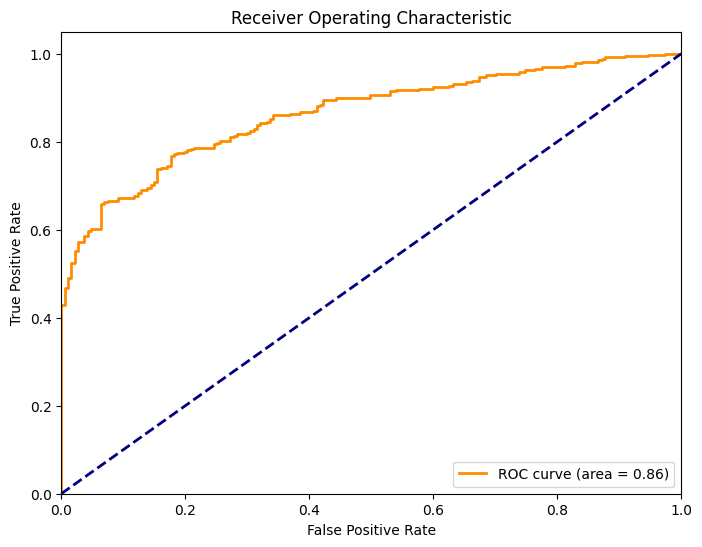

In [ ]:
# Evaluation on test set
def evaluate_model_with_generator(model, test_gen, steps=50):
    # Test metrics
    test_losses = []
    test_accuracies = []
    test_aucs = []
    test_precisions = []
    test_recalls = []


    all_predictions = []
    all_true_labels = []

    for step in range(steps):
        X_test_batch, y_test_batch = next(iter(test_gen))

        # Test on batch
        test_metrics = model.test_on_batch(X_test_batch, y_test_batch)

        # metrics
        test_losses.append(test_metrics[0])
        test_accuracies.append(test_metrics[1])
        test_aucs.append(test_metrics[2])
        test_precisions.append(test_metrics[3])
        test_recalls.append(test_metrics[4])

        # predictions
        batch_predictions = model.predict(X_test_batch)
        all_predictions.extend(batch_predictions.flatten())
        all_true_labels.extend(y_test_batch)

        gc.collect()

    # average metrics
    avg_test_loss = np.mean(test_losses)
    avg_test_accuracy = np.mean(test_accuracies)
    avg_test_auc = np.mean(test_aucs)
    avg_test_precision = np.mean(test_precisions)
    avg_test_recall = np.mean(test_recalls)

    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {avg_test_accuracy:.4f}")
    print(f"Test AUC: {avg_test_auc:.4f}")
    print(f"Test Precision: {avg_test_precision:.4f}")
    print(f"Test Recall: {avg_test_recall:.4f}")

    binary_predictions = (np.array(all_predictions) > 0.5).astype(int)

    from sklearn.metrics import roc_curve, auc

    fpr, tpr, _ = roc_curve(all_true_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

# Evaluation
test_results = evaluate_model_with_generator(model, test_gen, steps=50)
